# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

The challenge choised was:
## Patterns and predictive modelling of traffic accidents.

The proposed solution is to analyse the data, find patterns with clustering techniques and build a predictive model of traffic accidents at street level by a period of the day to understand the causes of traffic accidents and try to antecipate the general traffic accidents.

## Development
Start coding here! 🐱‍🏍

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

In [1413]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import sklearn
import datetime as dt
from datetime import date
import requests

import folium
from folium.plugins import MarkerCluster
from branca.element import Figure

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
#from pmdarima.arima import auto_arima
from math import sqrt
from scipy import stats
from scipy.stats import normaltest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,mean_absolute_error

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [184]:
# We won't use this dataset because the geojson is more complete 
#df = pd.read_csv('Traffic_Collisions.csv')

In [445]:
r = requests.get('https://opendata.arcgis.com/datasets/75fa68b17e5b421d9d881f987c2d43fc_0.geojson')
data = r.json()
data.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [446]:
# look at the first item
data['features'][0]

{'type': 'Feature',
 'properties': {'OBJECTID': 1,
  'ACCIDENTNUM': '13-118637',
  'ACCIDENTDATE': '20130525',
  'LOCATION': 'CEDAR ST N @ KING ST E / CEDAR ST S',
  'ACCIDENT_LOCATION': '02-Intersection related',
  'IMPACT_LOCATION': '02-Thru lane',
  'ENVIRONMENT_CONDITION': '01-Clear',
  'LIGHT': '01-Daylight',
  'COLLISION_TYPE': 'INTERSECTION',
  'TRAFFICCOLLISIONSID': None},
 'geometry': {'type': 'MultiPoint',
  'coordinates': [[-80.4834355873955, 43.4473369881122]]}}

In [447]:
data_feat = data['features']

In [448]:
len(data_feat)

12201

In [449]:
df_prop = [i['properties'] for i in data_feat]
df_geo = [i['geometry'] for i in data_feat]

In [450]:
df_p = pd.DataFrame(columns=['OBJECTID','ACCIDENTNUM','ACCIDENTDATE','LOCATION','ACCIDENT_LOCATION','IMPACT_LOCATION','ENVIRONMENT_CONDITION','LIGHT','COLLISION_TYPE',\
                             'TRAFFICCOLLISIONSID'])
df_g = pd.DataFrame(columns=['coordinates','type'])

In [451]:
for i in df_prop:
    a = i['OBJECTID']
    b = i['ACCIDENTNUM']
    c = i['ACCIDENTDATE']
    d = i['LOCATION']
    e = i['ACCIDENT_LOCATION']
    f = i['IMPACT_LOCATION']
    g = i['ENVIRONMENT_CONDITION']
    h = i['LIGHT']
    j = i['COLLISION_TYPE']
    l = i['TRAFFICCOLLISIONSID']
    
    df_p = df_p.append({'OBJECTID':a ,'ACCIDENTNUM':b,  'ACCIDENTDATE':c, 'LOCATION':d, 'ACCIDENT_LOCATION':e, 'IMPACT_LOCATION':f,'ENVIRONMENT_CONDITION':g,'LIGHT':h,\
                        'COLLISION_TYPE':j, 'TRAFFICCOLLISIONSID':l}, ignore_index = True)

In [452]:
df_p.shape

(12201, 10)

In [453]:
for i in df_geo:
    a = i['coordinates']
    b = i['type']
    
    df_g = df_g.append({'coordinates':a, 'type':b}, ignore_index=True)

In [454]:
df_g.shape

(12201, 2)

In [455]:
df_g['c'] = [j for i in df_g['coordinates'] for j in i]
df_g['long'] =  [i[0] for i in df_g['c']]
df_g['lat'] =  [i[1] for i in df_g['c']]

In [456]:
df_g.head()

coordinates        type  \
0  [[-80.4834355873955, 43.4473369881122]]  MultiPoint   
1   [[-80.5169945442686, 43.451888379849]]  MultiPoint   
2  [[-80.4834355873955, 43.4473369881122]]  MultiPoint   
3  [[-80.5184363622389, 43.4541804514074]]  MultiPoint   
4  [[-80.4662220764058, 43.3919732819579]]  MultiPoint   

                                       c       long        lat  
0  [-80.4834355873955, 43.4473369881122] -80.483436  43.447337  
1   [-80.5169945442686, 43.451888379849] -80.516995  43.451888  
2  [-80.4834355873955, 43.4473369881122] -80.483436  43.447337  
3  [-80.5184363622389, 43.4541804514074] -80.518436  43.454180  
4  [-80.4662220764058, 43.3919732819579] -80.466222  43.391973

In [457]:
df = pd.concat([df_p,df_g], axis=1, ignore_index=False)

In [458]:
df.head()

OBJECTID ACCIDENTNUM ACCIDENTDATE                             LOCATION  \
0        1   13-118637     20130525  CEDAR ST N @ KING ST E / CEDAR ST S   
1        2   13-019811     20130124           GLASGOW ST @ BELMONT AVE W   
2        3   12-089689     20120418  CEDAR ST N @ KING ST E / CEDAR ST S   
3        4   12-127500     20120601            BELMONT AVE W @ ARGYLE ST   
4        5   13-012564     20130115              STRASBURG RD @ HURON RD   

          ACCIDENT_LOCATION         IMPACT_LOCATION ENVIRONMENT_CONDITION  \
0   02-Intersection related            02-Thru lane              01-Clear   
1  04-At/near private drive            02-Thru lane              01-Clear   
2       01-Non intersection       09-Right shoulder              01-Clear   
3        03-At intersection  01-Within intersection               02-Rain   
4        03-At intersection  01-Within intersection              01-Clear   

                 LIGHT COLLISION_TYPE TRAFFICCOLLISIONSID  \
0          01-Daylight   INTERSECTION                None   
1          01-Daylight   INTERSECTION                None   
2          01-Daylight   INTERSECTION                None   
3          01-Daylight   INTERSECTION                None   
4  08-Dark, artificial   INTERSECTION                None   

                               coordinates        type  \
0  [[-80.4834355873955, 43.4473369881122]]  MultiPoint   
1   [[-80.5169945442686, 43.451888379849]]  MultiPoint   
2  [[-80.4834355873955, 43.4473369881122]]  MultiPoint   
3  [[-80.5184363622389, 43.4541804514074]]  MultiPoint   
4  [[-80.4662220764058, 43.3919732819579]]  MultiPoint   

                                       c       long        lat  
0  [-80.4834355873955, 43.4473369881122] -80.483436  43.447337  
1   [-80.5169945442686, 43.451888379849] -80.516995  43.451888  
2  [-80.4834355873955, 43.4473369881122] -80.483436  43.447337  
3  [-80.5184363622389, 43.4541804514074] -80.518436  43.454180  
4  [-80.4662220764058, 43.3919732819579] -80.466222  43.391973

In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12201 entries, 0 to 12200
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OBJECTID               12201 non-null  object 
 1   ACCIDENTNUM            12201 non-null  object 
 2   ACCIDENTDATE           12201 non-null  object 
 3   LOCATION               12201 non-null  object 
 4   ACCIDENT_LOCATION      12186 non-null  object 
 5   IMPACT_LOCATION        12165 non-null  object 
 6   ENVIRONMENT_CONDITION  12147 non-null  object 
 7   LIGHT                  12094 non-null  object 
 8   COLLISION_TYPE         12201 non-null  object 
 9   TRAFFICCOLLISIONSID    0 non-null      object 
 10  coordinates            12201 non-null  object 
 11  type                   12201 non-null  object 
 12  c                      12201 non-null  object 
 13  long                   12201 non-null  float64
 14  lat                    12201 non-null  float64
dtypes:

In [460]:
df.OBJECTID = df.OBJECTID.astype(int)
df.ACCIDENTDATE = df.ACCIDENTDATE.astype(int)

In [461]:
df.isnull().sum()

OBJECTID                     0
ACCIDENTNUM                  0
ACCIDENTDATE                 0
LOCATION                     0
ACCIDENT_LOCATION           15
IMPACT_LOCATION             36
ENVIRONMENT_CONDITION       54
LIGHT                      107
COLLISION_TYPE               0
TRAFFICCOLLISIONSID      12201
coordinates                  0
type                         0
c                            0
long                         0
lat                          0
dtype: int64

In [462]:
df.type.value_counts()

MultiPoint    12201
Name: type, dtype: int64

In [463]:
# drop the missing values and the features that doesn't add information to the problem
df.drop(['TRAFFICCOLLISIONSID','coordinates','type','c'], axis = 1, inplace=True)
df = df.dropna()

In [464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12045 entries, 0 to 12200
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OBJECTID               12045 non-null  int32  
 1   ACCIDENTNUM            12045 non-null  object 
 2   ACCIDENTDATE           12045 non-null  int32  
 3   LOCATION               12045 non-null  object 
 4   ACCIDENT_LOCATION      12045 non-null  object 
 5   IMPACT_LOCATION        12045 non-null  object 
 6   ENVIRONMENT_CONDITION  12045 non-null  object 
 7   LIGHT                  12045 non-null  object 
 8   COLLISION_TYPE         12045 non-null  object 
 9   long                   12045 non-null  float64
 10  lat                    12045 non-null  float64
dtypes: float64(2), int32(2), object(7)
memory usage: 1.0+ MB


In [465]:
# convert accidentdate in datetime
def get_data(df, column):
    
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    
    return year, month, day    

In [466]:
df['Accident_Date'] = pd.to_datetime(df.ACCIDENTDATE, format='%Y%m%d')

In [467]:
df.head()

OBJECTID ACCIDENTNUM  ACCIDENTDATE                             LOCATION  \
0         1   13-118637      20130525  CEDAR ST N @ KING ST E / CEDAR ST S   
1         2   13-019811      20130124           GLASGOW ST @ BELMONT AVE W   
2         3   12-089689      20120418  CEDAR ST N @ KING ST E / CEDAR ST S   
3         4   12-127500      20120601            BELMONT AVE W @ ARGYLE ST   
4         5   13-012564      20130115              STRASBURG RD @ HURON RD   

          ACCIDENT_LOCATION         IMPACT_LOCATION ENVIRONMENT_CONDITION  \
0   02-Intersection related            02-Thru lane              01-Clear   
1  04-At/near private drive            02-Thru lane              01-Clear   
2       01-Non intersection       09-Right shoulder              01-Clear   
3        03-At intersection  01-Within intersection               02-Rain   
4        03-At intersection  01-Within intersection              01-Clear   

                 LIGHT COLLISION_TYPE       long        lat Accident_Date  
0          01-Daylight   INTERSECTION -80.483436  43.447337    2013-05-25  
1          01-Daylight   INTERSECTION -80.516995  43.451888    2013-01-24  
2          01-Daylight   INTERSECTION -80.483436  43.447337    2012-04-18  
3          01-Daylight   INTERSECTION -80.518436  43.454180    2012-06-01  
4  08-Dark, artificial   INTERSECTION -80.466222  43.391973    2013-01-15

In [468]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12045 entries, 0 to 12200
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   OBJECTID               12045 non-null  int32         
 1   ACCIDENTNUM            12045 non-null  object        
 2   ACCIDENTDATE           12045 non-null  int32         
 3   LOCATION               12045 non-null  object        
 4   ACCIDENT_LOCATION      12045 non-null  object        
 5   IMPACT_LOCATION        12045 non-null  object        
 6   ENVIRONMENT_CONDITION  12045 non-null  object        
 7   LIGHT                  12045 non-null  object        
 8   COLLISION_TYPE         12045 non-null  object        
 9   long                   12045 non-null  float64       
 10  lat                    12045 non-null  float64       
 11  Accident_Date          12045 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(2), object(7)
memory

In [469]:
df.tail()

OBJECTID ACCIDENTNUM  ACCIDENTDATE  \
12196     12197   17-170078      20170731   
12197     12198   17-160025      20170719   
12198     12199   17-119913      20170602   
12199     12200   17-164929      20170725   
12200     12201   17-170792      20170801   

                                               LOCATION  \
12196          MCBRINE DR btwn MCINTYRE DR & MCBRINE PL   
12197             MANOR DR btwn LEWIS CRES & LEWIS CRES   
12198          QUEENS BLVD btwn PATRICIA AVE & NORTH DR   
12199          VANIER DR btwn SIEBERT AVE & TRAYNOR AVE   
12200  WINDING WAY btwn CHERRYTREE CRT & WESTHEIGHTS DR   

              ACCIDENT_LOCATION IMPACT_LOCATION ENVIRONMENT_CONDITION  \
12196       01-Non intersection    02-Thru lane              01-Clear   
12197  04-At/near private drive    02-Thru lane              01-Clear   
12198  04-At/near private drive  12-Off highway              01-Clear   
12199  04-At/near private drive    02-Thru lane              01-Clear   
12200       01-Non intersection    02-Thru lane              01-Clear   

             LIGHT COLLISION_TYPE       long        lat Accident_Date  
12196  01-Daylight       MIDBLOCK -80.475772  43.402429    2017-07-31  
12197  01-Daylight       MIDBLOCK -80.416198  43.426118    2017-07-19  
12198  01-Daylight       MIDBLOCK -80.502399  43.437869    2017-06-02  
12199  01-Daylight       MIDBLOCK -80.455952  43.421111    2017-07-25  
12200  01-Daylight       MIDBLOCK -80.537861  43.419685    2017-08-01

In [470]:
plt.rcParams["figure.figsize"]=25,5

Below we can see in which conditions the traffic accidents most occur during the analyzed time

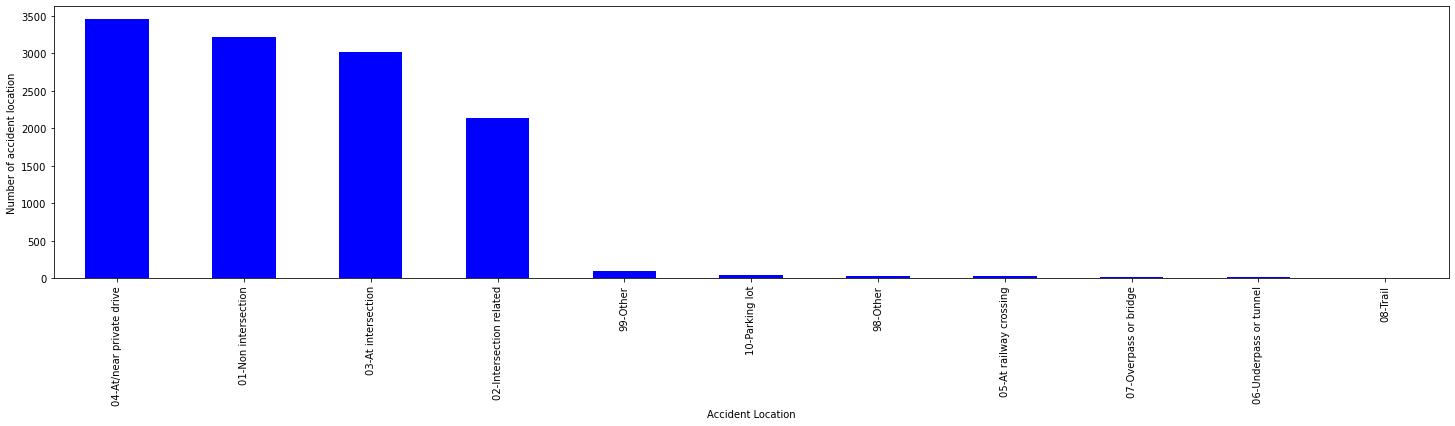

In [473]:
df.ACCIDENT_LOCATION.value_counts().plot.bar(color=['b'])
plt.xlabel('Accident Location')
plt.ylabel('Number of accident location')
plt.show()

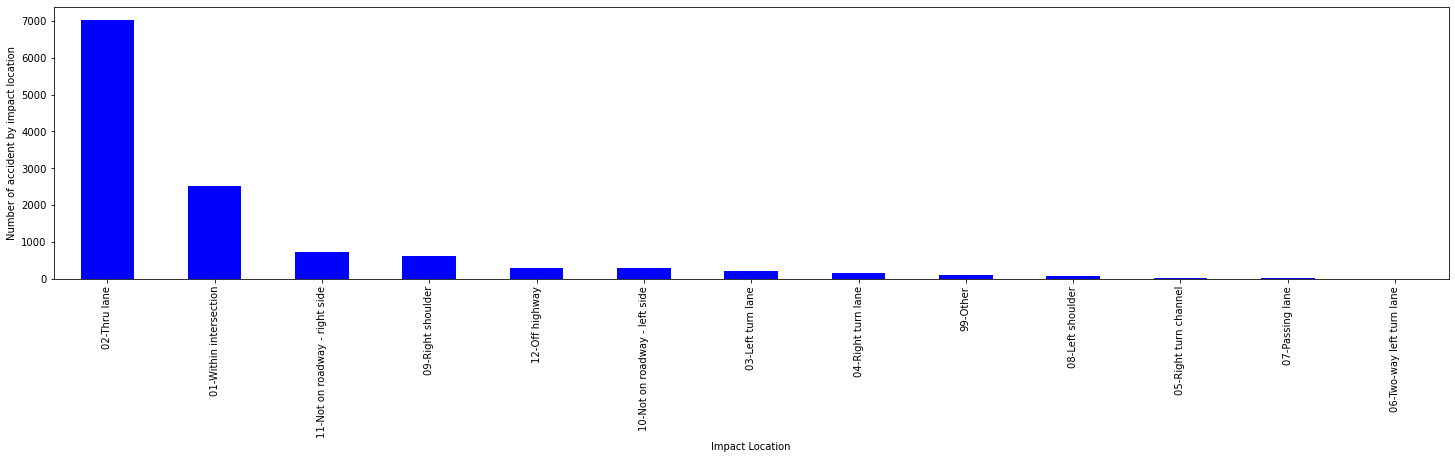

In [474]:
df.IMPACT_LOCATION.value_counts().plot.bar(color=['b'])
plt.xlabel('Impact Location')
plt.ylabel('Number of accident by impact location')
plt.show()

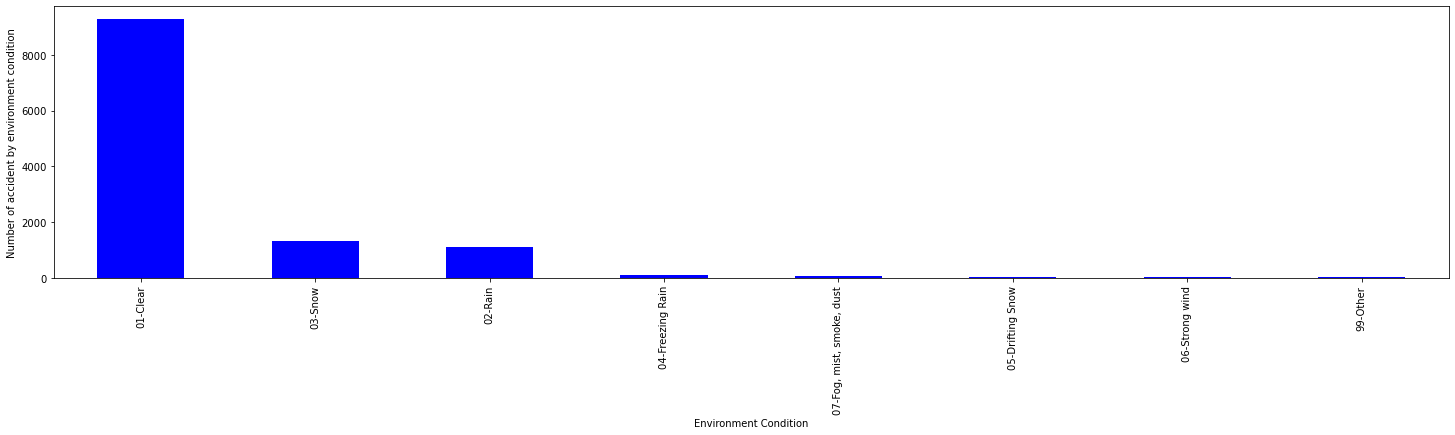

In [475]:
df.ENVIRONMENT_CONDITION.value_counts().plot.bar(color=['b'])
plt.xlabel('Environment Condition')
plt.ylabel('Number of accident by environment condition')
plt.show()

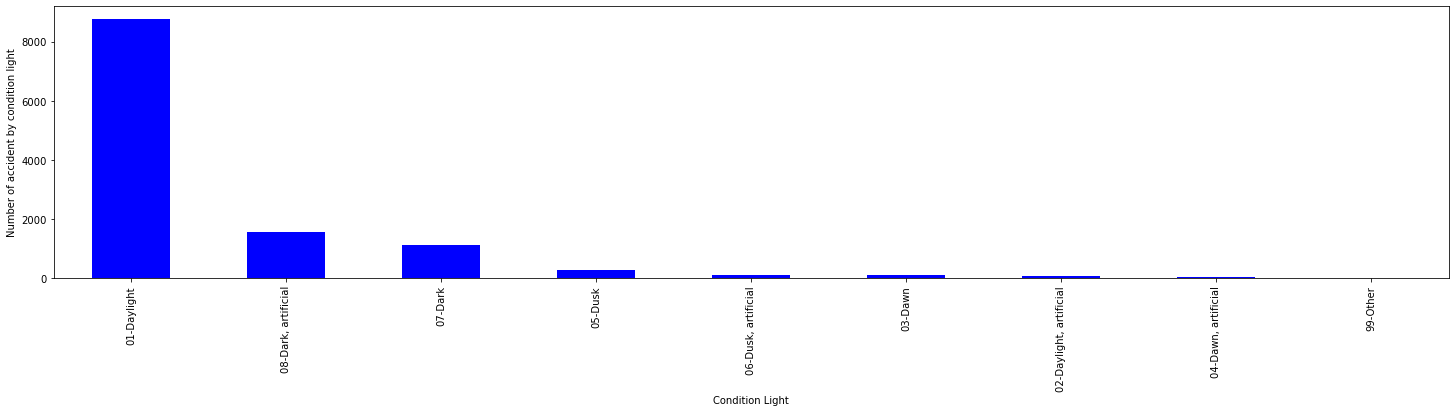

In [476]:
df.LIGHT.value_counts().plot.bar(color=['b'])
plt.xlabel('Condition Light')
plt.ylabel('Number of accident by condition light')
plt.show()

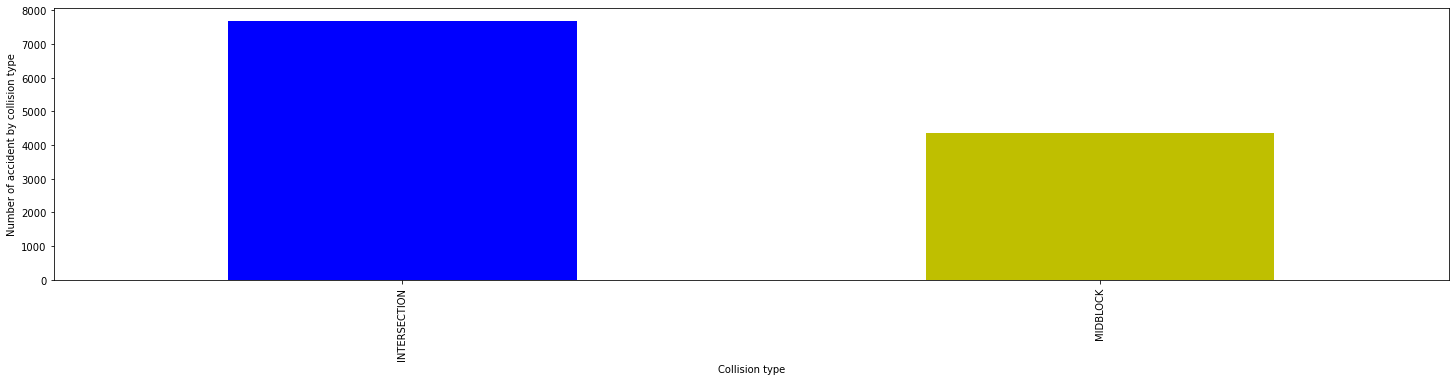

In [477]:
df.COLLISION_TYPE.value_counts().plot.bar(color=['b','y'])
plt.xlabel('Collision type')
plt.ylabel('Number of accident by collision type')
plt.show()

### Below we show the accidents in the map to allow see the accident distribution in this city.

#### We can see where are the location with most accident and we can click on the point to zoom in and see the accidents by street level

In [1565]:
coord = df[['lat', 'long']]
locationlist = coord.values.tolist()

In [1576]:
map = folium.Map(location=[43.4490, -80.4882], zoom_start=12)
marker_cluster = folium.plugins.MarkerCluster().add_to(map)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
map

In [478]:
max(df.Accident_Date)

Timestamp('2018-02-23 00:00:00')

In [479]:
min(df.Accident_Date)

Timestamp('2005-01-01 00:00:00')

In [480]:
df['weekday'] = df.Accident_Date.dt.weekday
df['year'] = df.Accident_Date.dt.year
df['month'] = df.Accident_Date.dt.month
df['date'] = df.Accident_Date.dt.date

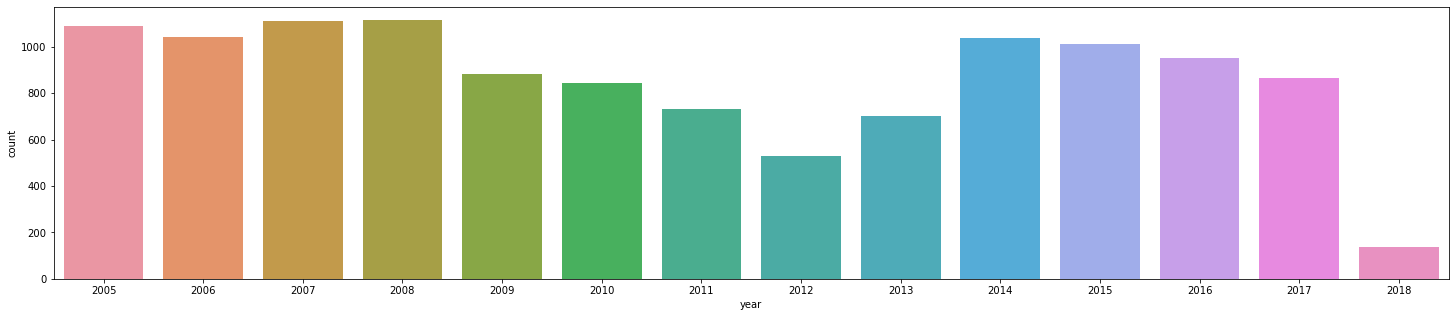

In [481]:
sns.countplot(x='year', data = df)

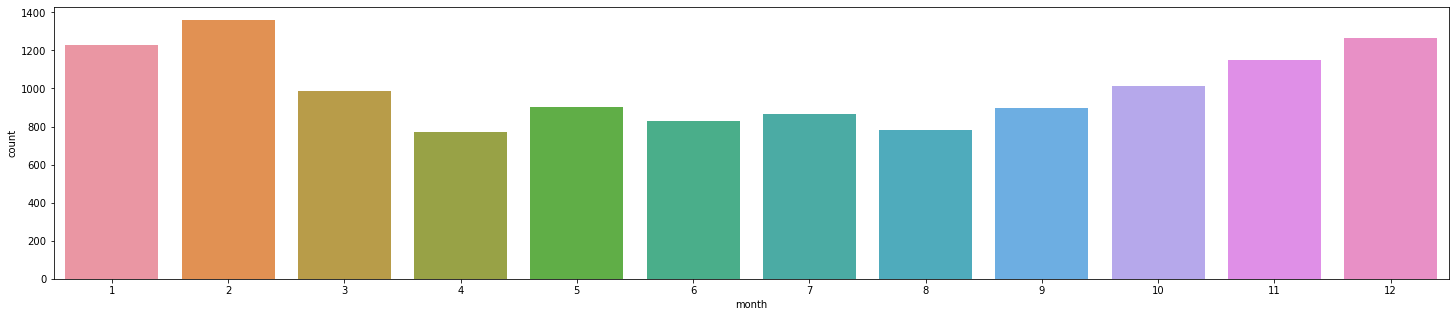

In [482]:
sns.countplot(x='month', data = df)

In [483]:
df_day = df.weekday.value_counts().reset_index().rename(columns={'index': 'weekday', 'weekday': 'Total'})
df_day['day'] = df_day['weekday'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})

In [484]:
df_day = df_day.sort_values(['weekday'], ascending = True)

In [485]:
df_day

weekday  Total  day
4        0   1704  Mon
1        1   1839  Tue
3        2   1789  Wed
2        3   1820  Thu
0        4   2074  Fri
5        5   1620  Sat
6        6   1199  Sun

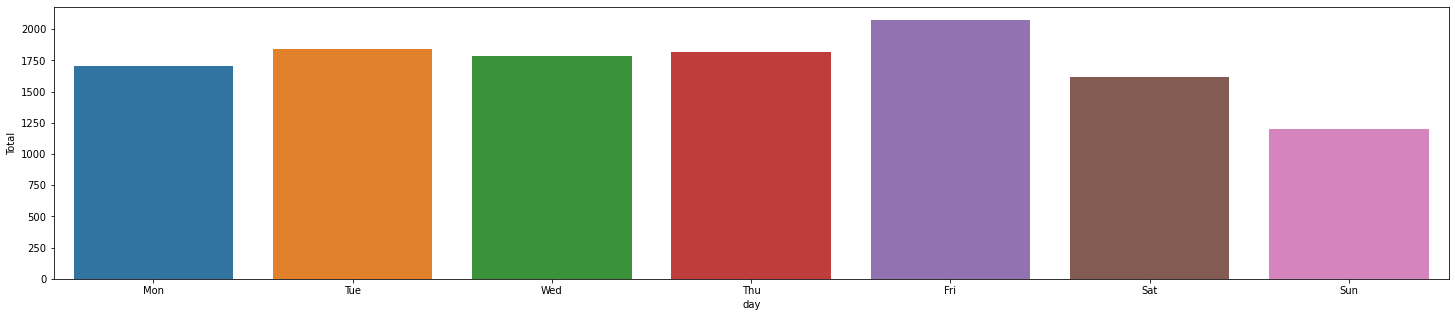

In [486]:
sns.barplot(x='day', y='Total', data = df_day)

In [970]:
df_da = df.date.value_counts().reset_index().rename(columns={'index': 'Date', 'date': 'Total'})
df_da = df_da.sort_values(['Date'], ascending = True)
df_da = df_da.reset_index(drop=True)
df_da['Accident_Date'] = pd.to_datetime(df_da.Date, format='%Y-%m-%d')
df_da['weekday'] = df_da.Accident_Date.dt.weekday
df_da['day'] = df_da['weekday'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df_da.head()

Date  Total Accident_Date  weekday  day
0  2005-01-01      2    2005-01-01        5  Sat
1  2005-01-02      2    2005-01-02        6  Sun
2  2005-01-03      3    2005-01-03        0  Mon
3  2005-01-04      5    2005-01-04        1  Tue
4  2005-01-05      2    2005-01-05        2  Wed

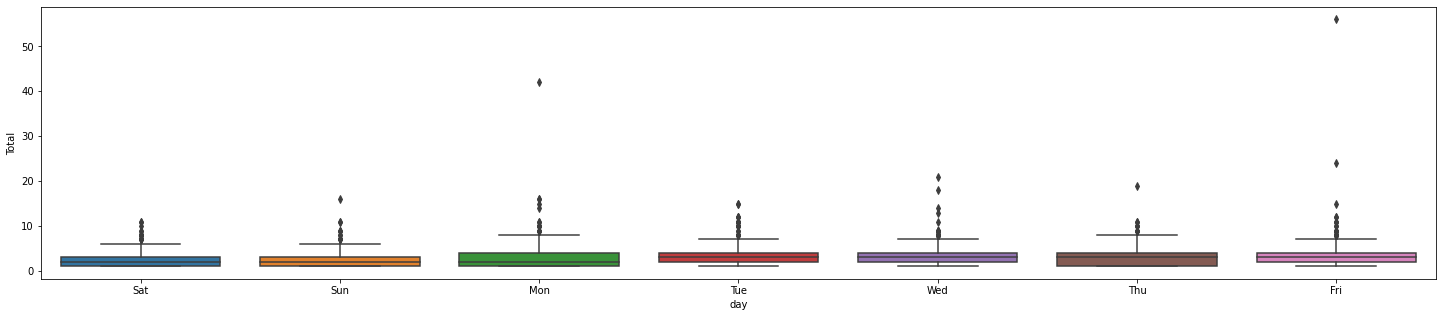

In [971]:
sns.boxplot(x='day', y='Total', data=df_da)
plt.show()

We can see that there is not much difference in the number of accidents per day of the week, but on Friday due to some high number of accidents, this seems to be the day that most accidents occur

In [489]:
df.head()

OBJECTID ACCIDENTNUM  ACCIDENTDATE                             LOCATION  \
0         1   13-118637      20130525  CEDAR ST N @ KING ST E / CEDAR ST S   
1         2   13-019811      20130124           GLASGOW ST @ BELMONT AVE W   
2         3   12-089689      20120418  CEDAR ST N @ KING ST E / CEDAR ST S   
3         4   12-127500      20120601            BELMONT AVE W @ ARGYLE ST   
4         5   13-012564      20130115              STRASBURG RD @ HURON RD   

          ACCIDENT_LOCATION         IMPACT_LOCATION ENVIRONMENT_CONDITION  \
0   02-Intersection related            02-Thru lane              01-Clear   
1  04-At/near private drive            02-Thru lane              01-Clear   
2       01-Non intersection       09-Right shoulder              01-Clear   
3        03-At intersection  01-Within intersection               02-Rain   
4        03-At intersection  01-Within intersection              01-Clear   

                 LIGHT COLLISION_TYPE       long        lat Accident_Date  \
0          01-Daylight   INTERSECTION -80.483436  43.447337    2013-05-25   
1          01-Daylight   INTERSECTION -80.516995  43.451888    2013-01-24   
2          01-Daylight   INTERSECTION -80.483436  43.447337    2012-04-18   
3          01-Daylight   INTERSECTION -80.518436  43.454180    2012-06-01   
4  08-Dark, artificial   INTERSECTION -80.466222  43.391973    2013-01-15   

   weekday  year  month        date  
0        5  2013      5  2013-05-25  
1        3  2013      1  2013-01-24  
2        2  2012      4  2012-04-18  
3        4  2012      6  2012-06-01  
4        1  2013      1  2013-01-15

In [1044]:
df_d = df.date.value_counts().reset_index().rename(columns={'index': 'Date', 'date': 'Total'})

In [1045]:
df_d = df_d.sort_values(['Date'], ascending = True)

In [1046]:
df_d['SMA_3'] = df_d.Total.rolling(window=3).mean()
df_d['std'] = df_d.Total.rolling(window=3).std()
df_d = df_d.reset_index(drop=True)

In [1047]:
df_d.head()

Date  Total     SMA_3       std
0  2005-01-01      2       NaN       NaN
1  2005-01-02      2       NaN       NaN
2  2005-01-03      3  2.333333  0.577350
3  2005-01-04      5  3.333333  1.527525
4  2005-01-05      2  3.333333  1.527525

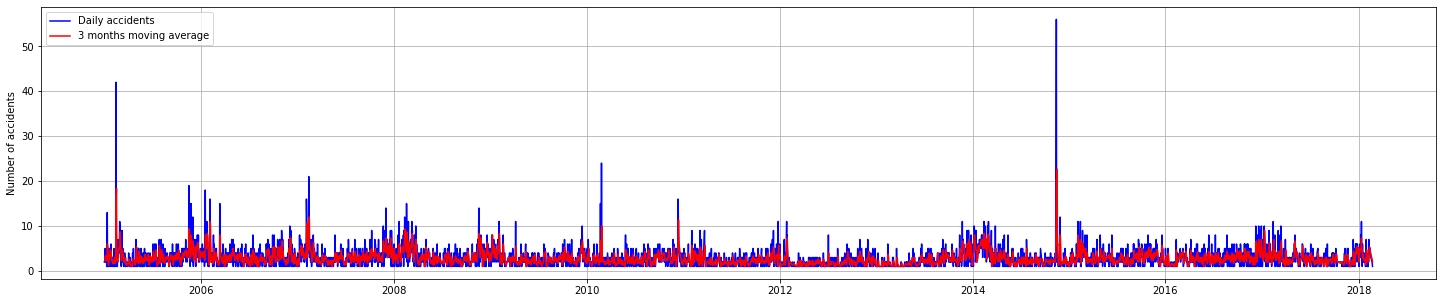

In [1048]:
plt.grid(True)
plt.plot(df_d.Date,df_d.Total,label='Daily accidents', color='b')
plt.plot(df_d.Date,df_d.SMA_3,label='3 months moving average',color='r')
plt.ylabel('Number of accidents')
plt.legend(loc=2)
plt.show()

<Figure size 1800x360 with 0 Axes>

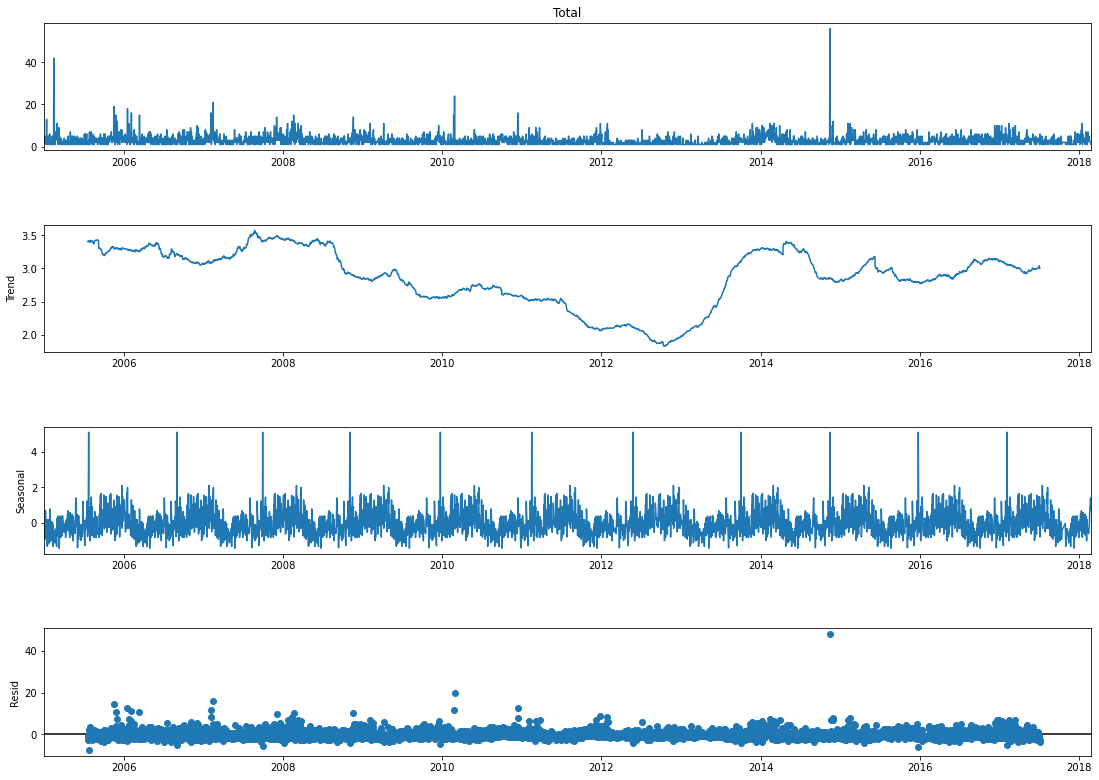

In [985]:
df_d = df_d.set_index('Date')
df_d['Total'] = df_d['Total'].astype(float)
result = seasonal_decompose(df_d['Total'], model='additive', period=365)
fig = plt.figure()  
fig = result.plot()
fig.set_size_inches(15, 12)

We can see that with some frequency there is an annual pattern and we can also see an upward trend so we conclude that the data is not stationary

### Looking in the last year of the data 2017-2018

In [1037]:
max(df['date'])

datetime.date(2018, 2, 23)

In [1052]:
df_d_ly = df[df['date'] > dt.date(2017,1,1)]

In [1053]:
df_d_ly = df_d_ly.date.value_counts().reset_index().rename(columns={'index': 'Date', 'date': 'Total'})

In [1054]:
df_d_ly = df_d_ly.sort_values(['Date'], ascending = True)

In [1055]:
df_d_ly['SMA_7'] = df_d_ly.iloc[:,1].rolling(window=7).mean()
df_d_ly['std'] = df_d_ly.iloc[:,1].rolling(window=7).std()

In [1056]:
df_d_ly.head()

Date  Total  SMA_7  std
314  2017-01-02      1    NaN  NaN
129  2017-01-03      3    NaN  NaN
131  2017-01-04      3    NaN  NaN
148  2017-01-05      3    NaN  NaN
87   2017-01-06      4    NaN  NaN

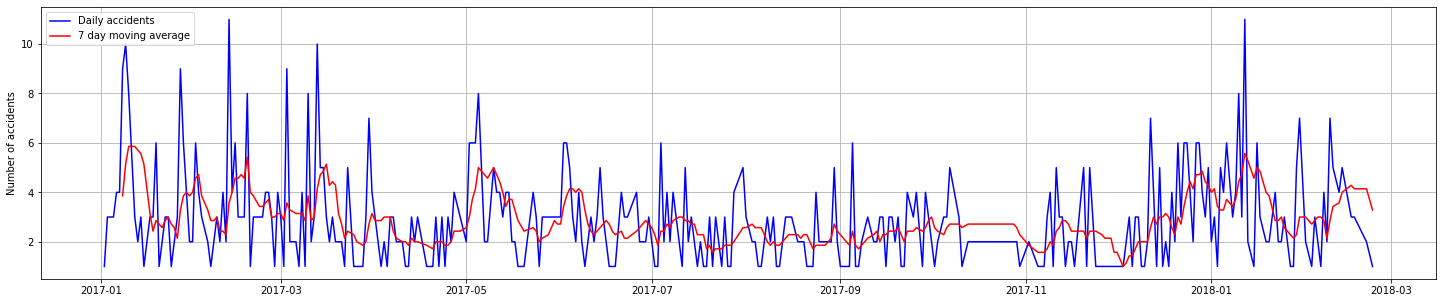

In [1057]:
plt.grid(True)
plt.plot(df_d_ly.Date, df_d_ly.Total, label = 'Daily accidents', color='b')
plt.plot(df_d_ly.Date,df_d_ly.SMA_7,label='7 day moving average', color='r')
plt.ylabel('Number of accidents')
plt.legend(loc=2)
plt.show()

### First predictive model only with number of accidents by date

In [1475]:
df_train = df[(df['date'] > dt.date(2014,1,22))&(df['date'] < dt.date(2017,10,22))]
df_train = df_train.date.value_counts().reset_index().rename(columns={'index': 'Date', 'date': 'Total'})
df_train= df_train.sort_values(['Date'], ascending = True)
df_train = df_train.reset_index(drop=True)
df_test = df[(df['date'] > dt.date(2017,10,22))&(df['date'] < dt.date(2018,2,22))]
df_test = df_test.date.value_counts().reset_index().rename(columns={'index': 'Date', 'date': 'Total'})
df_test.head()

Date  Total
0  2018-01-12     11
1  2018-01-10      8
2  2018-02-09      7
3  2018-01-30      7
4  2017-12-12      7

In [1476]:
x = df_train['Total'].values
result = adfuller(x, autolag='AIC', maxlag = 20 )
output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
cutoff = 0.01
for key,value in result[4].items():
        output['Critical Value (%s)'%key] = value
print(output)
if result[1] < cutoff:
    print('p-value = %.6f. Series is stationary.' % result[1])
else:
    print('p-value = %.6f. Series is non-stationary.' % result[1])    

Test Statistic                -6.739408e+00
p-value                        3.146653e-09
#Lags Used                     1.100000e+01
Number of Observations Used    1.194000e+03
Critical Value (1%)           -3.435839e+00
Critical Value (5%)           -2.863964e+00
Critical Value (10%)          -2.568060e+00
dtype: float64
p-value = 0.000000. Series is stationary.


In [1477]:
df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)

In [1478]:
df_train.index = pd.DatetimeIndex(df_train.index).to_period('D')
df_test.index = pd.DatetimeIndex(df_test.index).to_period('D')

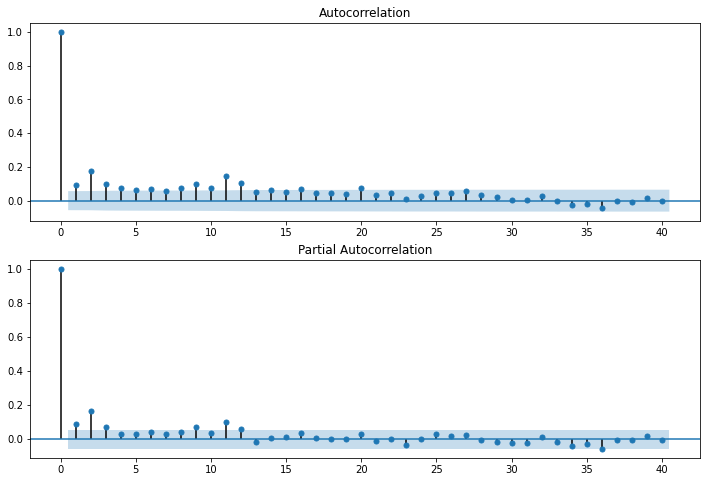

In [1479]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train['Total'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train['Total'],lags=40,ax=ax2)

In [1480]:
#ARIMA model
pred_model = ARIMA(df_train.Total, order=(4,1,0)).fit()

In [1481]:
print(pred_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Total   No. Observations:                 1205
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -2833.523
Method:                       css-mle   S.D. of innovations              2.540
Date:                Sat, 01 May 2021   AIC                           5679.045
Time:                        10:43:34   BIC                           5709.611
Sample:                    01-24-2014   HQIC                          5690.557
                         - 10-13-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0019      0.026     -0.075      0.940      -0.053       0.049
ar.L1.D.Total    -0.8026      0.028    -28.261      0.000      -0.858      -0.747
ar.L2.D.Total    -0.5151      0.035    -

NormaltestResult(statistic=1750.1748344284804, pvalue=0.0)


Text(0.5, 1.0, 'Residual distribution')

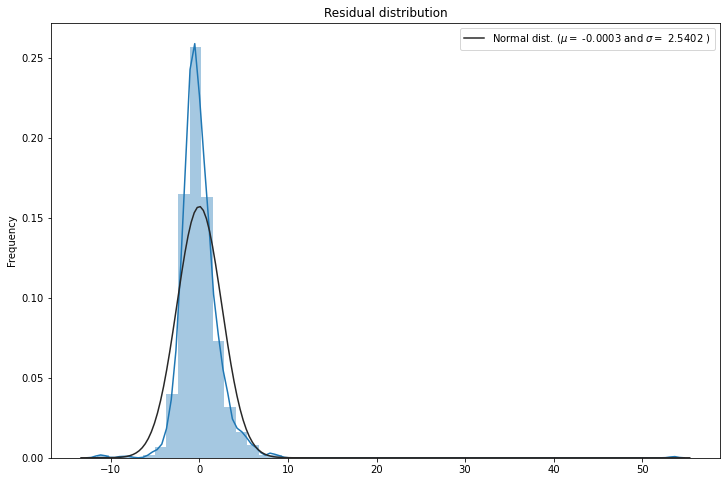

In [1482]:
resid = pred_model.resid
print(normaltest(resid))
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)
sns.distplot(resid ,fit = stats.norm, ax = ax0) 
(mu, sigma) = stats.norm.fit(resid)
plt.legend(['Normal dist. ($\mu=$ {:.4f} and $\sigma=$ {:.4f} )'.format(mu, sigma)])
plt.ylabel('Frequency')
plt.title('Residual distribution')

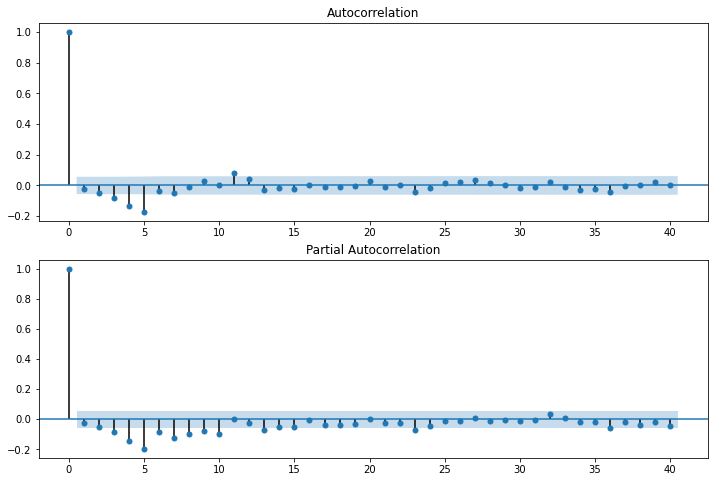

In [1483]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pred_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pred_model.resid, lags=40, ax=ax2)

In [1518]:
prediction = pred_model.forecast(steps=123)[0]
r = pd.date_range('22/10/2017', periods=123, freq='1D')
predictions = pd.DataFrame(prediction, index=r, columns=['Total_predict'])

In [1519]:
predictions.index = pd.DatetimeIndex(predictions.index).to_period('D')

In [1520]:
df_pred = pd.merge(predictions, df_test, left_index = True, right_index = True)
df_pred.index = df_pred.index.to_timestamp()
df_pred.head()

Total_predict  Total
2017-10-28       2.312503      2
2017-10-29       2.275774      2
2017-10-30       2.273703      1
2017-11-02       2.282197      2
2017-11-05       2.276152      1

In [1521]:
mae = mean_absolute_error(df_pred['Total'], df_pred['Total_predict'])
rmse = np.sqrt(mean_squared_error(df_pred['Total'], df_pred['Total_predict']))

In [1522]:
print(f"mean absolute error: {mae}")
print(f"root mean squared error: {rmse}")

mean absolute error: 1.57708176118227
root mean squared error: 2.16866388527277


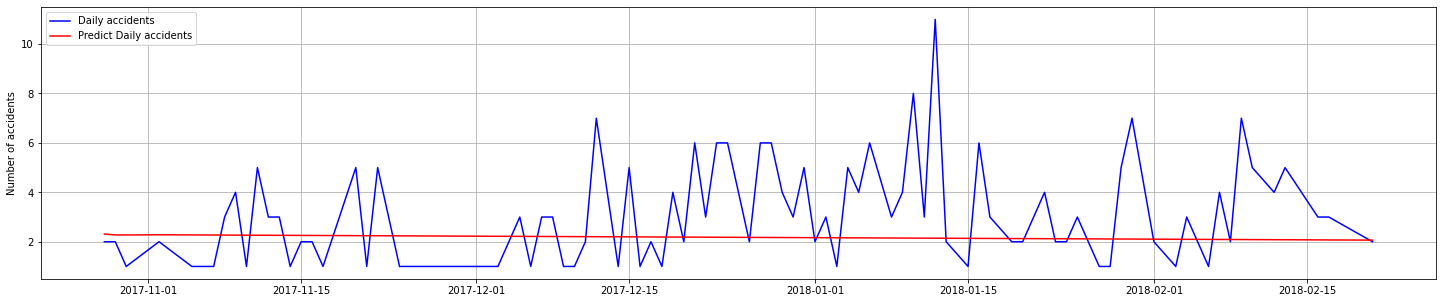

In [1523]:
plt.grid(True)
plt.plot(df_pred.index, df_pred.Total, label = 'Daily accidents', color='b')
plt.plot(df_pred.index,df_pred.Total_predict,label='Predict Daily accidents', color='r')
plt.ylabel('Number of accidents')
plt.legend(loc=2)
plt.show()

Using SARIMA predictive model only with number of accidents by date

In [1525]:
# SARIMA model
spred_model = sm.tsa.statespace.SARIMAX(df_train.Total, trend='n', order=(3,1,1)).fit()

In [1526]:
print(spred_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 1206
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -2753.614
Date:                Sat, 01 May 2021   AIC                           5517.229
Time:                        10:46:40   BIC                           5542.700
Sample:                    01-23-2014   HQIC                          5526.822
                         - 10-13-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0119      0.028      0.420      0.675      -0.044       0.068
ar.L2          0.1068      0.044      2.405      0.016       0.020       0.194
ar.L3          0.0230      0.045      0.516      0.6

NormaltestResult(statistic=1977.4706740038043, pvalue=0.0)


Text(0.5, 1.0, 'Residual distribution')

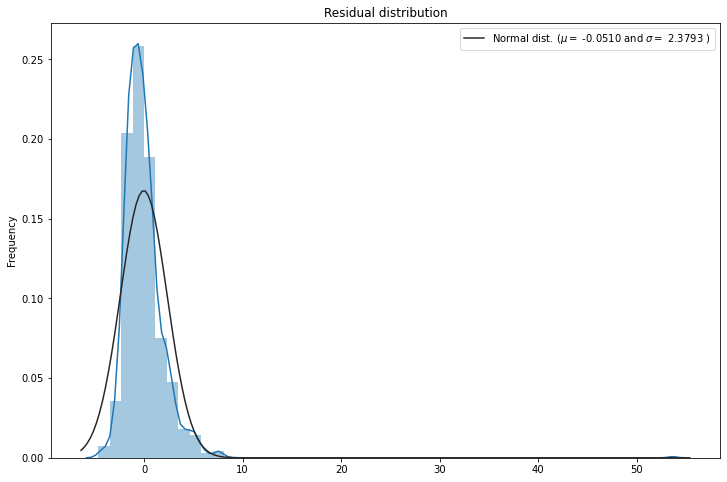

In [1527]:
resid = spred_model.resid
print(normaltest(resid))
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)
sns.distplot(resid ,fit = stats.norm, ax = ax0) 
(mu, sigma) = stats.norm.fit(resid)
plt.legend(['Normal dist. ($\mu=$ {:.4f} and $\sigma=$ {:.4f} )'.format(mu, sigma)])
plt.ylabel('Frequency')
plt.title('Residual distribution')

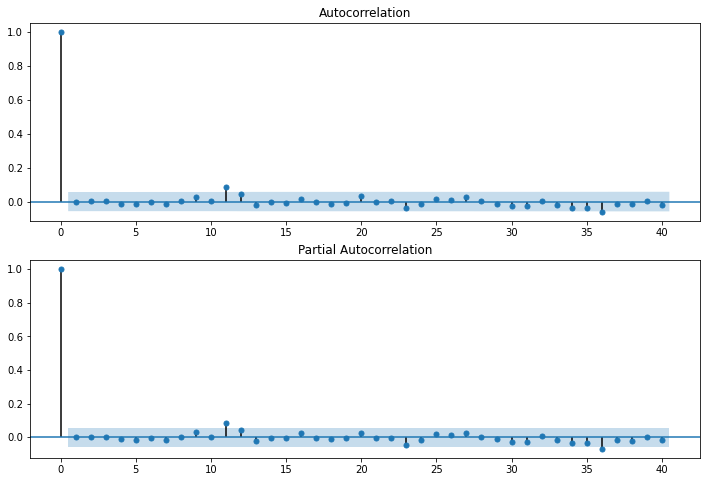

In [1528]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(spred_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(spred_model.resid, lags=40, ax=ax2)

In [1529]:
prediction = spred_model.forecast(steps=123)[0]
r = pd.date_range('22/10/2017', periods=123, freq='1D')
predictions = pd.DataFrame(prediction, index=r, columns=['Total_predict'])

In [1530]:
predictions.index = pd.DatetimeIndex(predictions.index).to_period('D')

In [1531]:
df_pred = pd.merge(predictions, df_test, left_index = True, right_index = True)
df_pred.index = df_pred.index.to_timestamp()
df_pred.head()

Total_predict  Total
2017-10-28       2.255698      2
2017-10-29       2.255698      2
2017-10-30       2.255698      1
2017-11-02       2.255698      2
2017-11-05       2.255698      1

In [1532]:
mae = mean_absolute_error(df_pred['Total'], df_pred['Total_predict'])
rmse = np.sqrt(mean_squared_error(df_pred['Total'], df_pred['Total_predict']))

In [1533]:
print(f"mean absolute error: {mae}")
print(f"root mean squared error: {rmse}")

mean absolute error: 1.5638297872340428
root mean squared error: 2.1252365137241473


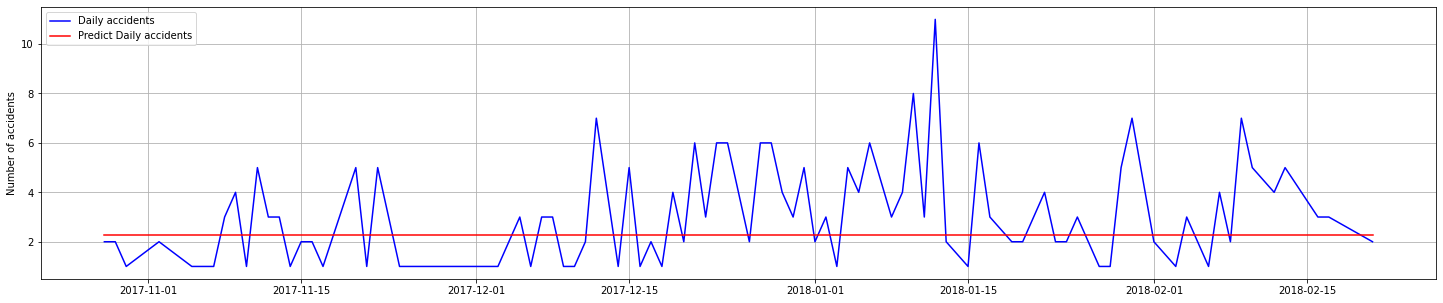

In [1534]:
plt.grid(True)
plt.plot(df_pred.index, df_pred.Total, label = 'Daily accidents', color='b')
plt.plot(df_pred.index,df_pred.Total_predict,label='Predict Daily accidents', color='r')
plt.ylabel('Number of accidents')
plt.legend(loc=2)
plt.show()

The dataset don't contain the hour of the accidents, only the date. Considering the outcome is a predictive model of traffic accidents at street level by a period of the day, we will use the Light feature for a period of the day. In another approach, we can using this feature to create a range of hours but it will vary by the months in the year and this can be done next time

In [534]:
df.LIGHT.value_counts()

01-Daylight                8751
08-Dark, artificial        1553
07-Dark                    1105
05-Dusk                     284
06-Dusk, artificial         119
03-Dawn                     105
02-Daylight, artificial      58
04-Dawn, artificial          52
99-Other                     18
Name: LIGHT, dtype: int64

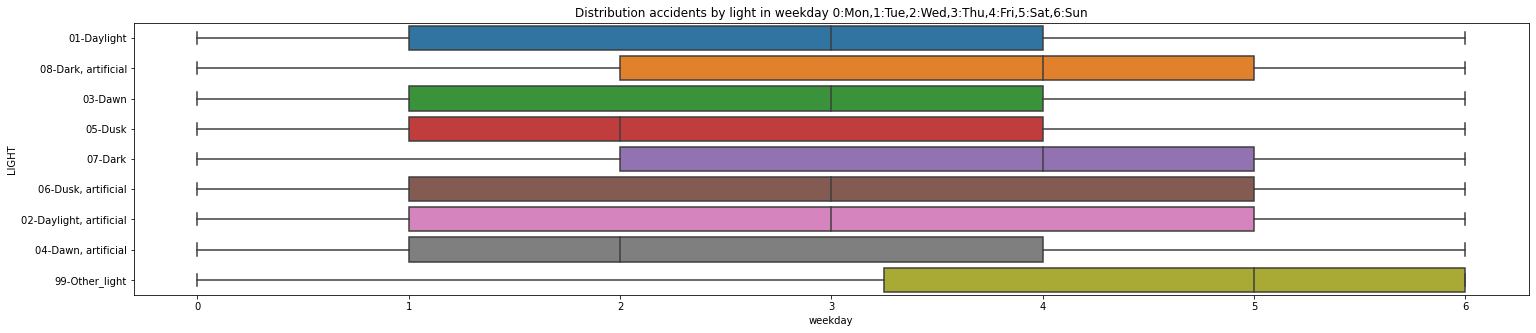

In [973]:
sns.boxplot(x='weekday', y='LIGHT', data=df)
plt.title('Distribution accidents by light in weekday 0:Mon,1:Tue,2:Wed,3:Thu,4:Fri,5:Sat,6:Sun')
plt.show()

In [1202]:
df.shape

(12045, 16)

In [1203]:
df['ACCIDENT_LOCATION'].mask(df['ACCIDENT_LOCATION'] == '99-Other', '99-Other_aclo', inplace=True)
df['IMPACT_LOCATION'].mask(df['IMPACT_LOCATION'] == '99-Other', '99-Other_imlo', inplace=True)
df['ENVIRONMENT_CONDITION'].mask(df['ENVIRONMENT_CONDITION'] == '99-Other', '99-Other_enco', inplace=True)
df['LIGHT'].mask(df['LIGHT'] == '99-Other', '99-Other_light', inplace=True)

#### Our approach is to use encoder in all categorical features to get the number of accidents at street level impacted by location, wheater conditions, period of the day, etc.

Creating multi-labels

In [1204]:
def types_data(data, column, name):
    
    type_list = data[column].apply(lambda x: list(x.split(",  ")))
    
    type_df = pd.DataFrame({name:type_list})
    
    return type_df    

In [1207]:
df_o = types_data(df, 'LOCATION', 'feature')
df_a = types_data(df, 'ACCIDENT_LOCATION', 'feature')
df_i = types_data(df, 'IMPACT_LOCATION', 'feature')
df_e = types_data(df, 'ENVIRONMENT_CONDITION', 'feature')
df_l = types_data(df, 'LIGHT', 'feature')
df_c = types_data(df, 'COLLISION_TYPE', 'feature')

In [1208]:
df_accloc.head()

feature
0   [02-Intersection related]
1  [04-At/near private drive]
2       [01-Non intersection]
3        [03-At intersection]
4        [03-At intersection]

In [1209]:
mlb = MultiLabelBinarizer()
df_oo = pd.DataFrame(mlb.fit_transform(df_o["feature"]),columns=mlb.classes_)
df_aa = pd.DataFrame(mlb.fit_transform(df_a["feature"]),columns=mlb.classes_)
df_ii = pd.DataFrame(mlb.fit_transform(df_i["feature"]),columns=mlb.classes_)
df_ee = pd.DataFrame(mlb.fit_transform(df_e["feature"]),columns=mlb.classes_)
df_ll = pd.DataFrame(mlb.fit_transform(df_l["feature"]),columns=mlb.classes_)
df_cc = pd.DataFrame(mlb.fit_transform(df_c["feature"]),columns=mlb.classes_)

In [1210]:
df.reset_index(drop=True, inplace=True)
df_oo.reset_index(drop=True, inplace=True)
df_aa.reset_index(drop=True, inplace=True)
df_aa.reset_index(drop=True, inplace=True)
df_ii.reset_index(drop=True, inplace=True)
df_ee.reset_index(drop=True, inplace=True)
df_ll.reset_index(drop=True, inplace=True)
df_cc.reset_index(drop=True, inplace=True)

In [1211]:
conc_list = [df,df_oo,df_aa,df_ii,df_ee,df_ll,df_cc]

In [1212]:
df_conc = pd.concat(conc_list, axis=1)

In [1213]:
df_conc.shape

(12045, 2515)

In [1214]:
len(list(df_conc['OBJECTID'].unique()))

12045

In [1215]:
len(list(df_conc['ACCIDENTNUM'].unique()))

12044

In [1216]:
# drop the the features that doesn't add information to the problem because are unique values
df_conc.drop(['OBJECTID','ACCIDENTNUM'], axis = 1, inplace=True)

In [1217]:
df_conc.head(2)

ACCIDENTDATE                             LOCATION  \
0      20130525  CEDAR ST N @ KING ST E / CEDAR ST S   
1      20130124           GLASGOW ST @ BELMONT AVE W   

          ACCIDENT_LOCATION IMPACT_LOCATION ENVIRONMENT_CONDITION  \
0   02-Intersection related    02-Thru lane              01-Clear   
1  04-At/near private drive    02-Thru lane              01-Clear   

         LIGHT COLLISION_TYPE       long        lat Accident_Date  weekday  \
0  01-Daylight   INTERSECTION -80.483436  43.447337    2013-05-25        5   
1  01-Daylight   INTERSECTION -80.516995  43.451888    2013-01-24        3   

   year  month        date  ABERDEEN RD @ CLAREMONT AVE  \
0  2013      5  2013-05-25                            0   
1  2013      1  2013-01-24                            0   

   ACTIVA AVE @ BERRY MOSS ST  ACTIVA AVE @ BRIDLEWREATH ST  \
0                           0                             0   
1                           0                             0   

   ACTIVA AVE @ COPPER LEAF ST  ACTIVA AVE @ DAVID BERGEY DR  \
0                            0                             0   
1                            0                             0   

   ACTIVA AVE @ HACKBERRY ST / GREY FOX DR  ACTIVA AVE @ HENHOEFFER CRES  \
0                                        0                             0   
1                                        0                             0   

   ACTIVA AVE @ ISAIAH DR  ACTIVA AVE @ MAX BECKER DR  \
0                       0                           0   
1                       0                           0   

   ACTIVA AVE @ PERIWINKLE ST  ACTIVA AVE @ SNOWDROP CRES  \
0                           0                           0   
1                           0                           0   

   ACTIVA AVE btwn BERRY MOSS ST & DAVID BERGEY DR  \
0                                                0   
1                                                0   

   ACTIVA AVE btwn DAVID BERGEY DR & ISAIAH DR  \
0                                            0   
1                                            0   

   ACTIVA AVE btwn DONNENWERTH DR & MAX BECKER DR  \
0                                               0   
1                                               0   

   ACTIVA AVE btwn FISCHER HALLMAN RD & GREY FOX DR  \
0                                                 0   
1                                                 0   

   ACTIVA AVE btwn GREY FOX DR & BUSH CLOVER CRES  \
0                                               0   
1                                               0   

   ACTIVA AVE btwn ISAIAH DR & SNOWDROP CRES  \
0                                          0   
1                                          0   

   ACTIVA AVE btwn MAX BECKER DR & BERRY MOSS ST  \
0                                              0   
1                                              0   

   ACTIVA AVE btwn PERIWINKLE ST & YARROW CRT  \
0                                           0   
1                                           0   

   ACTIVA AVE btwn SNOWDROP CRES & BRIDLEWREATH ST  \
0                                                0   
1                                                0   

   ACTIVA AVE btwn WILDERNESS DR & COPPER LEAF ST  \
0                                               0   
1                                               0   

   ADELAIDE ST btwn BELMONT AVE W & LAWRENCE AVE  \
0                                              0   
1                                              0   

   ADELAIDE ST btwn PATRICIA AVE & BELMONT AVE W  AGNES ST @ WALTER ST  \
0                                              0                     0   
1                                              0                     0   

   AHRENS ST E @ QUEEN ST N / AHRENS ST W  AHRENS ST W @ BREITHAUPT ST  \
0                                       0                            0   
1                                       0                            0   

   AHRENS ST W @ GUELPH ST  AHRENS ST W @ WELLINGTON ST N  \
0       

In [1218]:
df_conc.columns

Index(['ACCIDENTDATE', 'LOCATION', 'ACCIDENT_LOCATION', 'IMPACT_LOCATION',
       'ENVIRONMENT_CONDITION', 'LIGHT', 'COLLISION_TYPE', 'long', 'lat',
       'Accident_Date',
       ...
       '02-Daylight, artificial', '03-Dawn', '04-Dawn, artificial', '05-Dusk',
       '06-Dusk, artificial', '07-Dark', '08-Dark, artificial',
       '99-Other_light', 'INTERSECTION', 'MIDBLOCK'],
      dtype='object', length=2513)

Then we will group by LOCATION to count the number of accidents

In [1224]:
df_g = df_conc.groupby(['01-Non intersection', '02-Intersection related', '03-At intersection', '04-At/near private drive', '05-At railway crossing',\
                               '06-Underpass or tunnel', '07-Overpass or bridge', '08-Trail', '10-Parking lot', '98-Other', '99-Other_aclo', '01-Within intersection', '02-Thru lane',\
                                '03-Left turn lane', '04-Right turn lane', '05-Right turn channel', '06-Two-way left turn lane', '07-Passing lane', '08-Left shoulder',\
                               '09-Right shoulder', '10-Not on roadway - left side', '11-Not on roadway - right side', '12-Off highway', '99-Other_imlo', '01-Clear', '02-Rain', '03-Snow',\
                                '04-Freezing Rain', '05-Drifting Snow', '06-Strong wind', '07-Fog, mist, smoke, dust', '99-Other_enco', '01-Daylight', '02-Daylight, artificial', '03-Dawn',\
                                '04-Dawn, artificial', '05-Dusk', '06-Dusk, artificial', '07-Dark', '08-Dark, artificial', '99-Other_light', 'INTERSECTION',\
                               'MIDBLOCK','Accident_Date']).agg({'Accident_Date': ['count']})
df_g.columns = ['number_accidents']
df_g = df_g.sort_values(['Accident_Date'], ascending = True)
df_g = df_g.reset_index()
df_g.head(2)

01-Non intersection  02-Intersection related  03-At intersection  \
0                    0                        0                   1   
1                    0                        0                   0   

   04-At/near private drive  05-At railway crossing  06-Underpass or tunnel  \
0                         0                       0                       0   
1                         1                       0                       0   

   07-Overpass or bridge  08-Trail  10-Parking lot  98-Other  99-Other_aclo  \
0                      0         0               0         0              0   
1                      0         0               0         0              0   

   01-Within intersection  02-Thru lane  03-Left turn lane  \
0                       1             0                  0   
1                       0             1                  0   

   04-Right turn lane  05-Right turn channel  06-Two-way left turn lane  \
0                   0                      0                          0   
1                   0                      0                          0   

   07-Passing lane  08-Left shoulder  09-Right shoulder  \
0                0                 0                  0   
1                0                 0                  0   

   10-Not on roadway - left side  11-Not on roadway - right side  \
0                              0                               0   
1                              0                               0   

   12-Off highway  99-Other_imlo  01-Clear  02-Rain  03-Snow  \
0               0              0         0        1        0   
1               0              0         1        0        0   

   04-Freezing Rain  05-Drifting Snow  06-Strong wind  \
0                 0                 0               0   
1                 0                 0               0   

   07-Fog, mist, smoke, dust  99-Other_enco  01-Daylight  \
0                          0              0            0   
1                          0              0            1   

   02-Daylight, artificial  03-Dawn  04-Dawn, artificial  05-Dusk  \
0                        0        0                    0        0   
1                        0        0                    0        0   

   06-Dusk, artificial  07-Dark  08-Dark, artificial  99-Other_light  \
0                    0        1                    0               0   
1                    0        0                    0               0   

   INTERSECTION  MIDBLOCK Accident_Date  number_accidents  
0             1         0    2005-01-01                 1  
1             0         1    2005-01-01                 1

In [1225]:
df_g.shape

(10999, 45)

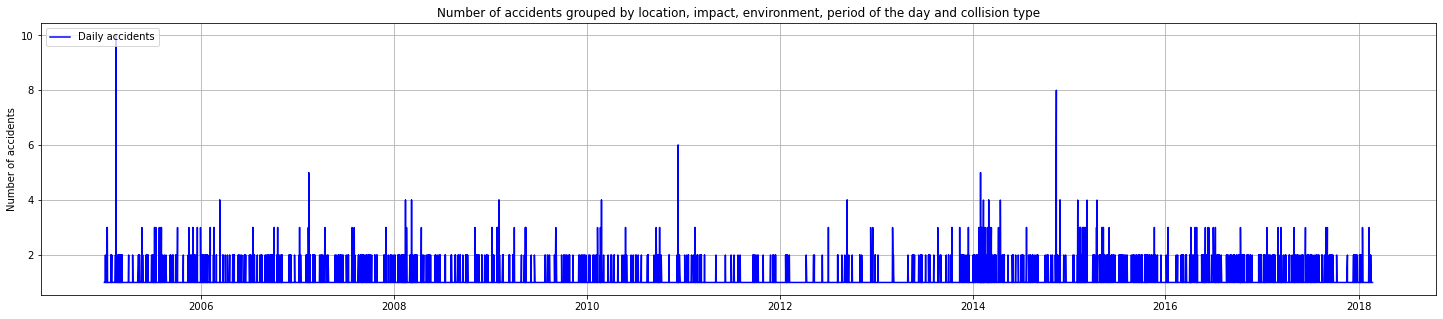

In [1226]:
plt.grid(True)
plt.plot(df_g.Accident_Date,df_g.number_accidents,label='Daily accidents', color='b')
plt.ylabel('Number of accidents')
plt.title('Number of accidents grouped by location, impact, environment, period of the day and collision type')
plt.legend(loc=2)
plt.show()

In [1228]:
df_g['date'] = df_g.Accident_Date.dt.date

In [1234]:
df_g = df_g.groupby(['01-Non intersection', '02-Intersection related', '03-At intersection', '04-At/near private drive', '05-At railway crossing',\
                               '06-Underpass or tunnel', '07-Overpass or bridge', '08-Trail', '10-Parking lot', '98-Other', '99-Other_aclo', '01-Within intersection', '02-Thru lane',\
                                '03-Left turn lane', '04-Right turn lane', '05-Right turn channel', '06-Two-way left turn lane', '07-Passing lane', '08-Left shoulder',\
                               '09-Right shoulder', '10-Not on roadway - left side', '11-Not on roadway - right side', '12-Off highway', '99-Other_imlo', '01-Clear', '02-Rain', '03-Snow',\
                                '04-Freezing Rain', '05-Drifting Snow', '06-Strong wind', '07-Fog, mist, smoke, dust', '99-Other_enco', '01-Daylight', '02-Daylight, artificial', '03-Dawn',\
                                '04-Dawn, artificial', '05-Dusk', '06-Dusk, artificial', '07-Dark', '08-Dark, artificial', '99-Other_light', 'INTERSECTION',\
                               'MIDBLOCK','date']).agg({'number_accidents': np.sum})
df_g.columns = ['number_accidents']
df_g = df_g.sort_values(['date'], ascending = True)
df_g = df_g.reset_index()
df_g.head(2)

01-Non intersection  02-Intersection related  03-At intersection  \
0                    0                        0                   1   
1                    0                        0                   0   

   04-At/near private drive  05-At railway crossing  06-Underpass or tunnel  \
0                         0                       0                       0   
1                         1                       0                       0   

   07-Overpass or bridge  08-Trail  10-Parking lot  98-Other  99-Other_aclo  \
0                      0         0               0         0              0   
1                      0         0               0         0              0   

   01-Within intersection  02-Thru lane  03-Left turn lane  \
0                       1             0                  0   
1                       0             1                  0   

   04-Right turn lane  05-Right turn channel  06-Two-way left turn lane  \
0                   0                      0                          0   
1                   0                      0                          0   

   07-Passing lane  08-Left shoulder  09-Right shoulder  \
0                0                 0                  0   
1                0                 0                  0   

   10-Not on roadway - left side  11-Not on roadway - right side  \
0                              0                               0   
1                              0                               0   

   12-Off highway  99-Other_imlo  01-Clear  02-Rain  03-Snow  \
0               0              0         0        1        0   
1               0              0         1        0        0   

   04-Freezing Rain  05-Drifting Snow  06-Strong wind  \
0                 0                 0               0   
1                 0                 0               0   

   07-Fog, mist, smoke, dust  99-Other_enco  01-Daylight  \
0                          0              0            0   
1                          0              0            1   

   02-Daylight, artificial  03-Dawn  04-Dawn, artificial  05-Dusk  \
0                        0        0                    0        0   
1                        0        0                    0        0   

   06-Dusk, artificial  07-Dark  08-Dark, artificial  99-Other_light  \
0                    0        1                    0               0   
1                    0        0                    0               0   

   INTERSECTION  MIDBLOCK        date  number_accidents  
0             1         0  2005-01-01                 1  
1             0         1  2005-01-01                 1

In [1238]:
def balanced_data(x):
    
    result = x.groupby(['date']).agg({'01-Non intersection': np.sum,
        '02-Intersection related': np.sum, '03-At intersection': np.sum, '04-At/near private drive': np.sum, '05-At railway crossing': np.sum,\
                               '06-Underpass or tunnel': np.sum, '07-Overpass or bridge': np.sum, '08-Trail': np.sum, '10-Parking lot': np.sum, '98-Other': np.sum,\
                                '99-Other_aclo': np.sum, '01-Within intersection': np.sum, '02-Thru lane': np.sum,\
                                '03-Left turn lane': np.sum, '04-Right turn lane': np.sum, '05-Right turn channel': np.sum, '06-Two-way left turn lane': np.sum,\
                                '07-Passing lane': np.sum, '08-Left shoulder': np.sum,\
                               '09-Right shoulder': np.sum, '10-Not on roadway - left side': np.sum, '11-Not on roadway - right side': np.sum, '12-Off highway': np.sum,\
                                '99-Other_imlo': np.sum, '01-Clear': np.sum, '02-Rain': np.sum, '03-Snow': np.sum,\
                                '04-Freezing Rain': np.sum, '05-Drifting Snow': np.sum, '06-Strong wind': np.sum, '07-Fog, mist, smoke, dust': np.sum, '99-Other_enco': np.sum,\
                                        '01-Daylight': np.sum, '02-Daylight, artificial': np.sum, '03-Dawn': np.sum,\
                                '04-Dawn, artificial': np.sum, '05-Dusk': np.sum, '06-Dusk, artificial': np.sum, '07-Dark': np.sum, '08-Dark, artificial': np.sum,\
                                        '99-Other_light': np.sum, 'INTERSECTION': np.sum,\
                               'MIDBLOCK': np.sum, 'number_accidents':np.sum})
    x = result[['01-Non intersection', '02-Intersection related', '03-At intersection', '04-At/near private drive', '05-At railway crossing',\
                               '06-Underpass or tunnel', '07-Overpass or bridge', '08-Trail', '10-Parking lot', '98-Other', '99-Other_aclo', '01-Within intersection', '02-Thru lane',\
                                '03-Left turn lane', '04-Right turn lane', '05-Right turn channel', '06-Two-way left turn lane', '07-Passing lane', '08-Left shoulder',\
                               '09-Right shoulder', '10-Not on roadway - left side', '11-Not on roadway - right side', '12-Off highway', '99-Other_imlo', '01-Clear', '02-Rain', '03-Snow',\
                                '04-Freezing Rain', '05-Drifting Snow', '06-Strong wind', '07-Fog, mist, smoke, dust', '99-Other_enco', '01-Daylight', '02-Daylight, artificial', '03-Dawn',\
                                '04-Dawn, artificial', '05-Dusk', '06-Dusk, artificial', '07-Dark', '08-Dark, artificial', '99-Other_light', 'INTERSECTION',\
                               'MIDBLOCK','number_accidents']]
    return x

In [1239]:
data_all = balanced_data(df_g)

In [1240]:
data_all.head()

01-Non intersection  02-Intersection related  03-At intersection  \
date                                                                           
2005-01-01                    0                        0                   1   
2005-01-02                    0                        0                   2   
2005-01-03                    0                        1                   0   
2005-01-04                    3                        0                   0   
2005-01-05                    0                        0                   1   

            04-At/near private drive  05-At railway crossing  \
date                                                           
2005-01-01                         1                       0   
2005-01-02                         0                       0   
2005-01-03                         2                       0   
2005-01-04                         2                       0   
2005-01-05                         0                       0   

            06-Underpass or tunnel  07-Overpass or bridge  08-Trail  \
date                                                                  
2005-01-01                       0                      0         0   
2005-01-02                       0                      0         0   
2005-01-03                       0                      0         0   
2005-01-04                       0                      0         0   
2005-01-05                       0                      0         0   

            10-Parking lot  98-Other  99-Other_aclo  01-Within intersection  \
date                                                                          
2005-01-01               0         0              0                       1   
2005-01-02               0         0              0                       1   
2005-01-03               0         0              0                       1   
2005-01-04               0         0              0                       0   
2005-01-05               0         0              0                       1   

            02-Thru lane  03-Left turn lane  04-Right turn lane  \
date                                                              
2005-01-01             1                  0                   0   
2005-01-02             1                  0                   0   
2005-01-03             2                  0                   0   
2005-01-04             5                  0                   0   
2005-01-05             0                  0                   0   

            05-Right turn channel  06-Two-way left turn lane  07-Passing lane  \
date                                                                            
2005-01-01                      0                          0                0   
2005-01-02                      0                          0                0   
2005-01-03                      0                          0                0   
2005-01-04                      0                          0                0   
2005-01-05                      0                          0                0   

            08-Left shoulder  09-Right shoulder  \
date                                              
2005-01-01                 0                  0   
2005-01-02                 0                  0   
2005-01-03                 0                  0   
2005-01-04                 0                  0   
2005-01-05                 0                  0   

            10-Not on roadway - left side  11-Not on roadway - right side  \
date                                                                        
2005-01-01                              0                               0   
2005-01-02                              0                               0   
2005-01-03                              0                               0   
2005-01-04                              0                               0   
2005-01-05                              0                               0   

            12

In [677]:
data_all = data_all.sort_values(['Accident_Date'], ascending = True)
data_all.shape

(2456, 45)

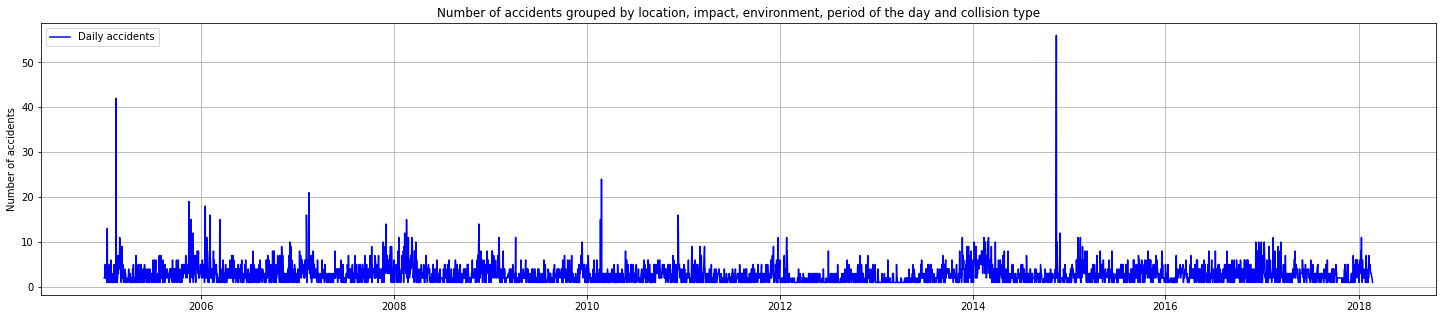

In [1241]:
plt.grid(True)
plt.plot(data_all.index,data_all.number_accidents,label='Daily accidents', color='b')
plt.ylabel('Number of accidents')
plt.title('Number of accidents grouped by location, impact, environment, period of the day and collision type')
plt.legend(loc=2)
plt.show()

In [1535]:
df_train = data_all[(data_all.index > dt.date(2014,1,22))&(data_all.index < dt.date(2017,10,22))]
df_test = data_all[(data_all.index > dt.date(2017,10,22))&(data_all.index < dt.date(2018,2,22))]
df_train.head()

01-Non intersection  02-Intersection related  03-At intersection  \
date                                                                           
2014-01-23                    1                        2                   0   
2014-01-24                    0                        0                   2   
2014-01-25                    0                        1                   0   
2014-01-26                    4                        0                   1   
2014-01-27                    2                        1                   1   

            04-At/near private drive  05-At railway crossing  \
date                                                           
2014-01-23                         2                       0   
2014-01-24                         2                       0   
2014-01-25                         1                       0   
2014-01-26                         0                       0   
2014-01-27                         1                       0   

            06-Underpass or tunnel  07-Overpass or bridge  08-Trail  \
date                                                                  
2014-01-23                       0                      0         0   
2014-01-24                       0                      0         0   
2014-01-25                       0                      0         0   
2014-01-26                       0                      0         0   
2014-01-27                       0                      0         0   

            10-Parking lot  98-Other  99-Other_aclo  01-Within intersection  \
date                                                                          
2014-01-23               0         0              0                       1   
2014-01-24               0         0              0                       1   
2014-01-25               0         0              0                       0   
2014-01-26               0         0              0                       1   
2014-01-27               0         0              0                       1   

            02-Thru lane  03-Left turn lane  04-Right turn lane  \
date                                                              
2014-01-23             2                  1                   0   
2014-01-24             2                  0                   0   
2014-01-25             2                  0                   0   
2014-01-26             2                  0                   0   
2014-01-27             4                  0                   0   

            05-Right turn channel  06-Two-way left turn lane  07-Passing lane  \
date                                                                            
2014-01-23                      0                          0                0   
2014-01-24                      0                          0                0   
2014-01-25                      0                          0                0   
2014-01-26                      0                          0                0   
2014-01-27                      0                          0                0   

            08-Left shoulder  09-Right shoulder  \
date                                              
2014-01-23                 0                  0   
2014-01-24                 0                  1   
2014-01-25                 0                  0   
2014-01-26                 0                  0   
2014-01-27                 0                  0   

            10-Not on roadway - left side  11-Not on roadway - right side  \
date                                                                        
2014-01-23                              0                               1   
2014-01-24                              0                               0   
2014-01-25                              0                               0   
2014-01-26                              0                               1   
2014-01-27                              0                               0   

            12

In [1536]:
df_train_ext = data_all[(data_all.index > dt.date(2014,1,22))&(data_all.index < dt.date(2017,10,22))]
df_train_ext.drop(['number_accidents'], axis = 1, inplace=True)
df_test_ext = data_all[(data_all.index > dt.date(2017,10,22))&(data_all.index < dt.date(2018,2,22))]
df_test_ext.drop(['number_accidents'], axis = 1, inplace=True)
df_train_ext.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


01-Non intersection  02-Intersection related  03-At intersection  \
date                                                                           
2014-01-23                    1                        2                   0   
2014-01-24                    0                        0                   2   
2014-01-25                    0                        1                   0   
2014-01-26                    4                        0                   1   
2014-01-27                    2                        1                   1   

            04-At/near private drive  05-At railway crossing  \
date                                                           
2014-01-23                         2                       0   
2014-01-24                         2                       0   
2014-01-25                         1                       0   
2014-01-26                         0                       0   
2014-01-27                         1                       0   

            06-Underpass or tunnel  07-Overpass or bridge  08-Trail  \
date                                                                  
2014-01-23                       0                      0         0   
2014-01-24                       0                      0         0   
2014-01-25                       0                      0         0   
2014-01-26                       0                      0         0   
2014-01-27                       0                      0         0   

            10-Parking lot  98-Other  99-Other_aclo  01-Within intersection  \
date                                                                          
2014-01-23               0         0              0                       1   
2014-01-24               0         0              0                       1   
2014-01-25               0         0              0                       0   
2014-01-26               0         0              0                       1   
2014-01-27               0         0              0                       1   

            02-Thru lane  03-Left turn lane  04-Right turn lane  \
date                                                              
2014-01-23             2                  1                   0   
2014-01-24             2                  0                   0   
2014-01-25             2                  0                   0   
2014-01-26             2                  0                   0   
2014-01-27             4                  0                   0   

            05-Right turn channel  06-Two-way left turn lane  07-Passing lane  \
date                                                                            
2014-01-23                      0                          0                0   
2014-01-24                      0                          0                0   
2014-01-25                      0                          0                0   
2014-01-26                      0                          0                0   
2014-01-27                      0                          0                0   

            08-Left shoulder  09-Right shoulder  \
date                                              
2014-01-23                 0                  0   
2014-01-24                 0                  1   
2014-01-25                 0                  0   
2014-01-26                 0                  0   
2014-01-27                 0                  0   

            10-Not on roadway - left side  11-Not on roadway - right side  \
date                                                                        
2014-01-23                              0                               1   
2014-01-24                              0                               0   
2014-01-25                              0                               0   
2014-01-26                              0                               1   
2014-01-27                              0                               0   

            12

In [1537]:
df_train.index = pd.DatetimeIndex(df_train.index).to_period('D')
df_test.index = pd.DatetimeIndex(df_test.index).to_period('D')
df_train_ext.index = pd.DatetimeIndex(df_train_ext.index).to_period('D')
df_test_ext.index = pd.DatetimeIndex(df_test_ext.index).to_period('D')

In [1564]:
%%time
start_index = 1368 
end_index = 1491
spred_model_2 = sm.tsa.statespace.SARIMAX(endog = df_train.number_accidents, exog = df_train_ext, trend='n', order=(6,1,0)).fit()
print(spred_model_2.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                               SARIMAX Results                                
Dep. Variable:       number_accidents   No. Observations:                 1206
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -1497.391
Date:                Sat, 01 May 2021   AIC                           3094.782
Time:                        11:02:38   BIC                           3349.494
Sample:                    01-23-2014   HQIC                          3190.710
                         - 10-13-2017                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
01-Non intersection               -1.1925      0.140     -8.515      0.000      -1.467      -0.918
02-Intersection related            4.1494      0.187     22.203      0.

In [1567]:
prediction = spred_model_2.forecast(steps=94, exog = df_test_ext)
r = pd.date_range('13/05/2017', periods=94, freq='1D')
predictions = pd.DataFrame(prediction, index=r, columns=['Total_predict'])
predictions.index = pd.DatetimeIndex(predictions.index).to_period('D')
predictions.head()

Total_predict
2017-05-13       1.439938
2017-05-14       1.555192
2017-05-15       0.925158
2017-05-16       1.786712
2017-05-17       0.767037

In [1568]:
df_test_a = data_all[(data_all.index > dt.date(2017,5,12))&(data_all.index < dt.date(2017,8,15))]
df_test_a.index = pd.DatetimeIndex(df_test_a.index).to_period('D')

In [1569]:
df_pred = pd.merge(predictions, df_test_a.number_accidents, left_index = True, right_index = True)
df_pred.index = df_pred.index.to_timestamp()
df_pred.head()

Total_predict  number_accidents
2017-05-13       1.439938                 3
2017-05-14       1.555192                 4
2017-05-15       0.925158                 4
2017-05-16       1.786712                 2
2017-05-17       0.767037                 2

In [1570]:
mae = mean_absolute_error(df_pred['number_accidents'], df_pred['Total_predict'])
rmse = np.sqrt(mean_squared_error(df_pred['number_accidents'], df_pred['Total_predict']))

In [1571]:
print(f"mean absolute error: {mae}")
print(f"root mean squared error: {rmse}")

mean absolute error: 2.2156021608581407
root mean squared error: 2.874067598125611


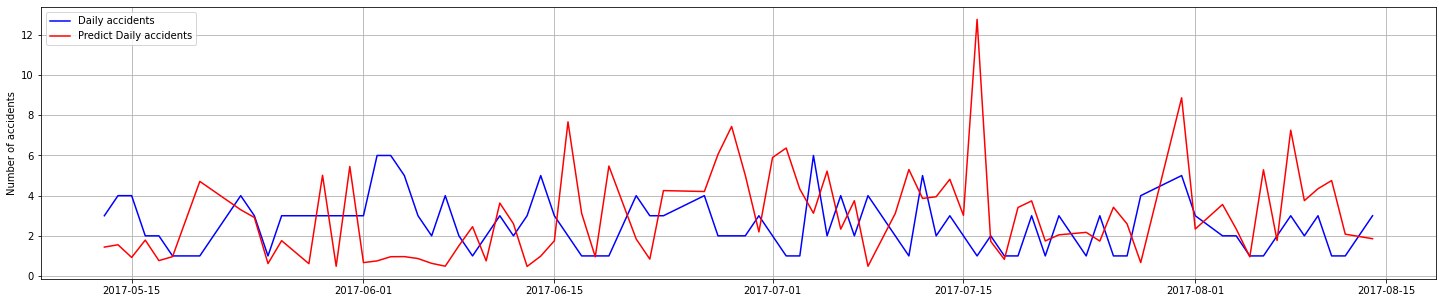

In [1574]:
plt.grid(True)
plt.plot(df_pred.index, df_pred.number_accidents, label = 'Daily accidents', color='b')
plt.plot(df_pred.index,df_pred.Total_predict,label='Predict Daily accidents', color='r')
plt.ylabel('Number of accidents')
plt.legend(loc=2)
plt.show()

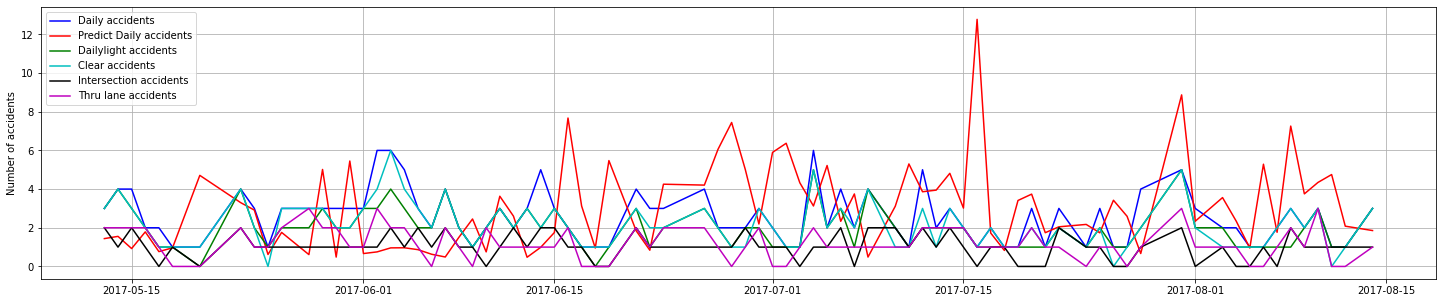

In [1586]:
plt.grid(True)
plt.plot(df_pred.index, df_pred.number_accidents, label = 'Daily accidents', color='b')
plt.plot(df_pred.index,df_pred.Total_predict,label='Predict Daily accidents', color='r')
plt.plot(df_pred.index, df_test_a['01-Daylight'], label = 'Dailylight accidents', color='g')
plt.plot(df_pred.index, df_test_a['01-Clear'], label = 'Clear accidents', color='c')
plt.plot(df_pred.index, df_test_a['INTERSECTION'], label = 'Intersection accidents', color='k')
plt.plot(df_pred.index, df_test_a['02-Thru lane'], label = 'Thru lane accidents', color='m')

plt.ylabel('Number of accidents')
plt.legend(loc=2)
plt.show()

Here we can see that when using the other categorical features the forecast is more predictive than just the number of accidents per day. We now need to see the influence of LOCATION on the forecast and hypertunning our SARIMA model.

As we were unable to finalize our analysis, we will more readily improve the model using only the features that have the most impact, such as:'01-Daylight', '01-Clear', 'INTERSECTION' and deriving by LOCATION

###  correlation with all dataset

In [1281]:
correlated_features = set()
correlation_matrix = data_all.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.6:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

We can see that the features most impact the number of accidents

In [1282]:
correlated_features

{'01-Daylight', '01-Within intersection', 'INTERSECTION', 'number_accidents'}

Text(0.5, 1.0, 'Pearson Correlation of Features')

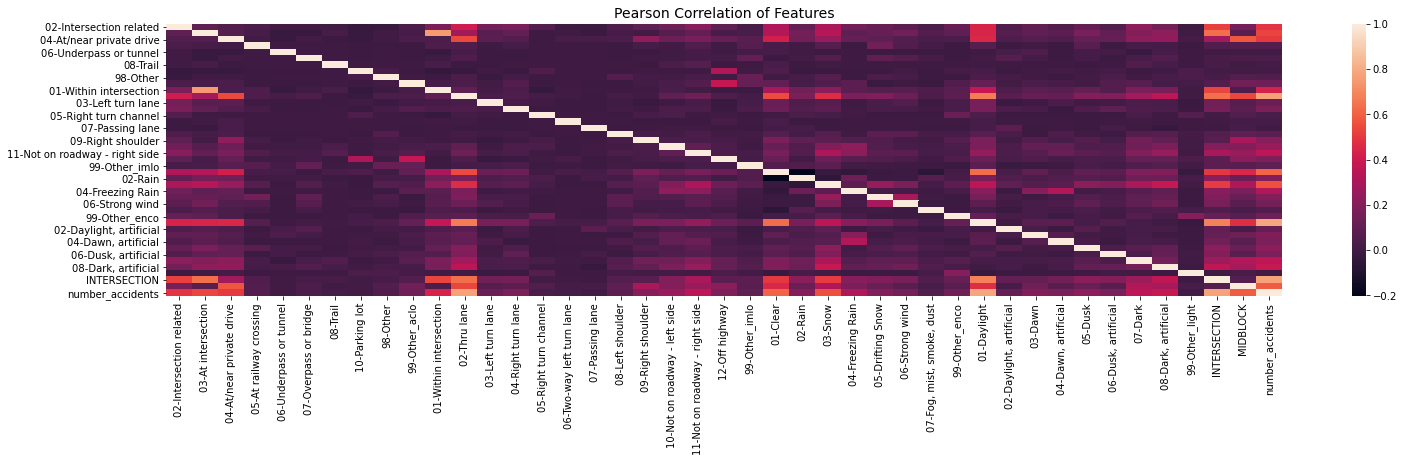

In [1283]:
# pearson coefficients with numeric variables
list_features = data_all.columns[1:].tolist()
data_num = data_all[list_features]
correlations = pd.DataFrame(data_num.corr())

sns.heatmap(correlations)
plt.title('Pearson Correlation of Features', size=14)

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

The analysis is not yet complete. To be applicable it is also necessary to refine the forecast at street level. To be scalable it is necessary to use Spark to process the data or even if they are used in chunk, which was not applied due to the need in the current dimension of the data used.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀

For a better analysis, we still needed to finish the forecast at street level during the period of the day. But if it were possible, we would still use the volume of cars that travel on the streets together with the weather forecast to help further prevent possible accidents.